# The clustering task: the k-means algorithm
### Master's Degree in Artificial Intelligence - Universidad de los Andes
#### By: Pedro Trujillo Vargas


In this last part of the project we will address the problem of determining the pattern of use of fossil fuels in countries to establish action plans that will mitigate their effects and generate alarms about pollution levels.

<a href="https://www.kaggle.com/datasets/ggsri123/co2-emissions-from-fossil-fuels"><img src="https://storage.googleapis.com/kaggle-datasets-images/1737920/2840163/b23a441514ebe183d44ec08468ddefbf/dataset-cover.jpg?t=2021-11-22-15-17-15" height="142" width="281" ></a>

**Goals:**

* Apply grouping techniques to build a descriptive model that allows **characterizing countries according to their levels of CO2 emissions due to the use of fossil fuels**.

* Determine **which are the factors that most affect CO2 pollution**.



## Activities to do:


1. [Data exploration and profiling](#1.-Data-exploration-and-profiling)
2. [Data cleaning and preparation](#2.-Data-cleaning-and-preparation)
3. [Construction of a clustering model using the k-means algorithm](#3.-Construction-of-a-clustering-model-using-the-k-means-algorithm)
4. [Interpretation of the groups resulting from the best model](#4.-Interpretation-of-the-resulting-groups-from-the-best-model)
5. [Results](#5-Results)

To begin, we load the necessary python libraries and the transformers that I have created for this exercise:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

## 1. Data exploration and profiling

Using the functionalities of the pandas library we will determine quality problems (for example, missing values ​​and duplicate records) and make decisions related to the preparation of the data for the learning algorithm.

#### Data Upload:

We will use **Pandas** to import the local file `./data/Data_Etapa-3.xlsx` that contains the data set. As we can see, this file is in excel format, which is why we need to use the `read_excel (<path>)` function to load the data into our dataframe:

In [2]:
ruta = './data/Datos_Etapa-3.xlsx' 
df = pd.read_excel(ruta, na_values=['?'])
df.head()

,"Year,Country,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels"
0,"2010,AFGHANISTAN,627,1601,74,5,0,0.08,9"
1,"2010,ALBANIA,117,953,7,177,0,0.43,7"
2,"2010,ALGERIA,332,12381,14565,2598,2623,0.9,663"
3,"2010,ANDORRA,0,141,0,0,0,1.68,0"
4,"2010,ANGOLA,0,3649,374,204,3697,0.37,321"


We can see that the data is not organized by columns, rather they are grouped as strings of characters in the same row/cell but separated by commas. Unfortunately the Pandas `read_excel` library does not allow comma separation, which lets us see that this file was most likely saved in the wrong format.

To do this, we will use the following code to iterate between all the rows and separate each string found by commas, which we know corresponds to an array of columns:


In [3]:
# fix the malformed dataframe based in the malformed excel, removing the last 2 columns too:
df_raw = df.iloc[:, 0].str.split(',', expand=True)
df_raw = df_raw.drop([9,10], axis=1)
df_raw.columns = [n.replace('"', '') for n in df.columns.str.split(',')[0]]
df_raw['Country'] = df_raw['Country'].replace('"BONAIRE', 'BONAIRE')
df_raw.head()

,Year,Country,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
0,2010,AFGHANISTAN,627,1601,74,5,0,0.08,9
1,2010,ALBANIA,117,953,7,177,0,0.43,7
2,2010,ALGERIA,332,12381,14565,2598,2623,0.9,663
3,2010,ANDORRA,0,141,0,0,0,1.68,0
4,2010,ANGOLA,0,3649,374,204,3697,0.37,321


We will proceed to analyze the data. First let's look at what form they have and compare it with the data dictionary:

In [4]:
df_raw.shape

(1094, 9)

We have 9 characteristics or variables and 1094 records of which the `Country` variable is categorical. At first glance we do not see that there is missing data.

#### Description

To have more information about the data, we are going to proceed to describe these assets that they have to tell us:

In [5]:
description = df_raw.describe()
description

,Year,Country,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
count,1094,1094,1094,1094,1094,1094,1094,1094,1094
unique,5,222,510,883,537,517,184,370,543
top,2012,AFGHANISTAN,0,54,0,0,0,0.02,0
freq,220,5,481,9,512,310,873,30,94


`Country` being a categorical variable changes the description of the data. Let's count the values ​​of this class to get the distribution of it:

In [6]:
pd.value_counts(df_raw["Country"])

AFGHANISTAN                     5
PAPUA NEW GUINEA                5
NEW ZEALAND                     5
NICARAGUA                       5
NIGER                           5
                               ..
REPUBLIC OF SOUTH SUDAN         3
REPUBLIC OF SUDAN               3
SAINT MARTIN (DUTCH PORTION)    3
SUDAN                           2
NETHERLAND ANTILLES             2
Name: Country, Length: 222, dtype: int64

We can see that the readings per year are not consistent for all countries, with some countries having records of only two years. It will be good to compare these observations with those provided by the data dictionary.
We load the data dictionary:

In [7]:
ruta_diccionario = './data/DiccionarioDatos_Etapa-3.xlsx'
diccionario = pd.read_excel(ruta_diccionario)
diccionario

,Columna,Tipo,Descripción
0,Year,numérico,Año de medición (2010-2014)
1,Country,categórica,Nombre del país
2,Solid Fuel,numérico,Emisiones de carbono por consumo de combustibl...
3,Liquid Fuel,numérico,Emisiones de carbono por consumo de combustibl...
4,Gas Fuel,numérico,Emisiones de carbono por consumo de gases (en ...
5,Cement,numérico,Emisiones de carbono por producción de cemento...
6,Gas Flaring,numérico,Emisiones de carbono por quema de gases (en to...
7,Per Capita,numérico,Emisiones de carbono per cápita (en toneladas ...
8,Bunker fuels,numérico,Emisiones de carbono por combustibles para bar...


In [8]:
assert df_raw.shape[1] == diccionario.shape[0], "The number of variables in the dataframe does not correspond to those recorded in the data dictionary"

We can see that according to the data dictionary, the shape of the dataframe corresponds to the correct number of variables, which is equal to 9

#### Verification and cleaning of invalid data:

Let's analyze each variable based on the data dictionary:

* `Year`: Year of measurement (2010-2014)
* `Country`: Name of the country
* `Solid Fuel`: Carbon emissions from consumption of solid fuels (in metric tons)
* `Liquid Fuel`: Carbon emissions from consumption of liquid fuels (in metric tons)
* `Gas Fuel`: Carbon emissions from gas consumption (in metric tons)
* `Cement`: Carbon emissions from cement production (in metric tons)
* `Gas Flaring`: Carbon emissions from gas flaring (in metric tons)
* `Per Capita`: Carbon emissions per capita (in metric tons)
* `Bunker fuels`: Carbon emissions from ship fuels (in metric tons)

Let's corroborate this, look at the data type with `data.dtypes`:

In [9]:
df_raw.dtypes

Year            object
Country         object
Solid Fuel      object
Liquid Fuel     object
Gas Fuel        object
Cement          object
Gas Flaring     object
Per Capita      object
Bunker fuels    object
dtype: object

All the data is of type `object` which is suspicious.

If we find invalid data, it will be necessary to replace it with `NaN` while we decide how to impute values ​​to it:

In [10]:
df_raw_copy = df_raw.copy()

colums_indexes = [0, 2, 3, 4, 5, 6, 7, 8]

for indexColumn in colums_indexes:
    columnName = df_raw_copy.columns[indexColumn]
    try:
        df_raw_copy[columnName] = pd.to_numeric(df_raw_copy[columnName])
    except ValueError:
        print(f"Error: la columna \'{columnName}\' contains non-numeric data, \n the non-numeric data has been replaced with NaN")
        df_raw_copy[columnName] = pd.to_numeric(df_raw_copy[columnName], errors='coerce')


Error: la columna 'Solid Fuel' contains non-numeric data, 
 the non-numeric data has been replaced with NaN
Error: la columna 'Liquid Fuel' contains non-numeric data, 
 the non-numeric data has been replaced with NaN


As we suspected, the data was not entirely numerical. Now let's check what they look like after removing the invalid data:

In [11]:
df_raw_copy.dtypes

Year              int64
Country          object
Solid Fuel      float64
Liquid Fuel     float64
Gas Fuel          int64
Cement            int64
Gas Flaring       int64
Per Capita      float64
Bunker fuels      int64
dtype: object

In [12]:
df_raw_copy.head()

,Year,Country,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
0,2010,AFGHANISTAN,627.0,1601.0,74,5,0,0.08,9
1,2010,ALBANIA,117.0,953.0,7,177,0,0.43,7
2,2010,ALGERIA,332.0,12381.0,14565,2598,2623,0.90,663
3,2010,ANDORRA,0.0,141.0,0,0,0,1.68,0
4,2010,ANGOLA,0.0,3649.0,374,204,3697,0.37,321


Let's check if the data for the year is within the range described in the dictionary


In [13]:
# Define a function to validate the ranges of columns in a given dataset
def validateRangesIn(columnsRangesDictionary, data):
    # Get a statistical summary of the dataset
    description = data.describe()
    
    # Iterate over the dictionary of columns and their expected ranges or categories
    for key, value in columnsRangesDictionary.items():
        print(" \n")
        
        # Check if the column is of type 'object' (categorical)
        if (data[key].dtype.name == 'object'):
            # Get the unique classes in the DataFrame for the column
            classesInDF = set(data[key].unique())
            # Get the expected categories from the dictionary
            categories = set(value)
            # Print whether the variable is categorical and its unique classes
            print("Is the variable " + key + " categorical?: " + str(data[key].unique()))
            # Print whether the classes in the DataFrame match the expected categories
            print(" Are the classes for " + key + ": " + str(classesInDF) + " \n equal to the expected: " + str(categories) + " ?: " + str(classesInDF == categories))
            # pd.value_counts(data[key])  # This line is commented out and can be used for additional class frequency information
        else:
            # If the column is numeric, check if its values are within the expected range
            minimo = value[0]  # Minimum expected value
            maximo = value[1]  # Maximum expected value
            # Print whether the variable is numeric
            print("Is the variable " + key + " numeric?: " + str(np.issubdtype(description[key].dtypes, np.number)))
            # Check if the values of the variable are within the specified range
            print(" Are the values of the variable within the range?: " + str(minimo <= description[key]["min"] and maximo >= description[key]["max"]))
            # Count the number of outliers below the minimum value
            menores = (data[key] < minimo).sum()
            print(" How many outliers or values less than " + str(minimo) + " are there?: " + str(menores))
            # Count the number of outliers above the maximum value
            mayores = (data[key] > maximo).sum()
            print(" How many outliers or values greater than " + str(maximo) + " are there?: " + str(mayores))
            # Calculate the number of values within the specified range
            print(" Values within the range: " + str(data.shape[0] - menores - mayores))

# Example dictionary of expected ranges or categories for variables
rangosPorVariable = { 
                        "Year": (2010, 2014),
                    }


Next we will analyze the ranges for the variables that have a defined range to verify if their values ​​are within the designated range and if not, show us how many values ​​are outside the ranges. And thus estimate the veracity of these in comparison with the dictionary:

In [14]:
validateRangesIn(rangosPorVariable, df_raw_copy)

 

Is the variable Year numeric?: True
 Are the values of the variable within the range?: True
 How many outliers or values less than 2010 are there?: 0
 How many outliers or values greater than 2014 are there?: 0
 Values within the range: 1094


By comparing with the data dictionary we can already say that the variables correspond to the expected data types and the year variable is within the expected range.


#### Analysis

Now the data is clearer. Based on the first objective of our model _"**characterize countries according to their levels of CO2 emissions due to the use of fossil fuels.**"_, the data dictionary and data analysis is an analysis of the years versus the numerical variables will give us a better idea of ​​what the correlation is between the other variables. Let's take a look at the current data relationship and distribution:

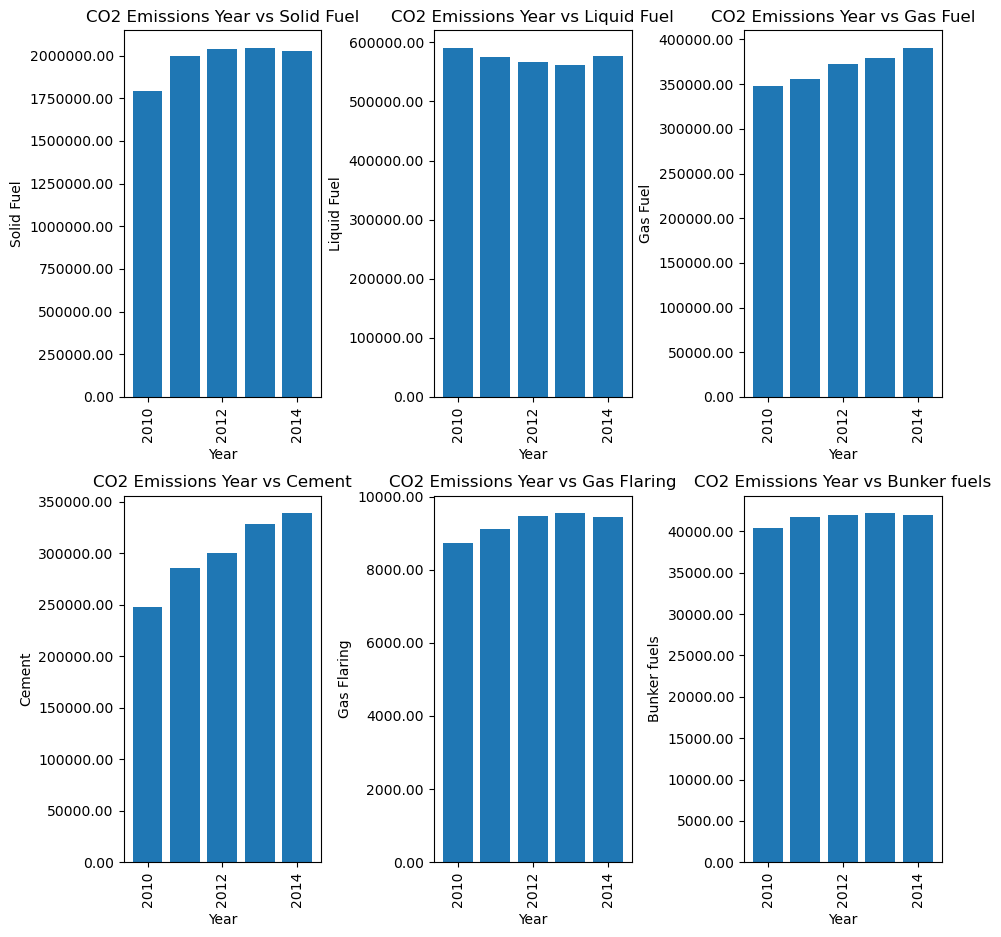

In [15]:
# Ensure inline display of plots in Jupyter notebooks
%matplotlib inline

# Drop specified columns from the dataset to create feature set x_data and target set y_data
x_data = df_raw_copy.drop(['Year', 'Country', 'Per Capita'], axis=1)
y_data = df_raw_copy['Year']

# Create a figure with a 2x3 grid of subplots, setting the overall figure size
figure2, axis2 = plt.subplots(2, 3, figsize=(10, 10))
# Flatten the axis array for easier indexing
flattenedAxis2 = axis2.flatten()
# Adjust the space between subplots
plt.subplots_adjust(hspace=0.8)
# Set padding for the overall layout
plt.tight_layout(pad=5.0)

# Initialize a counter for subplot indexing
i = 0
# Round the values in x_data to 2 decimal places
x_data = x_data.round(2)
# Iterate over the columns in x_data
for (columnName, columnData) in x_data.items():
    # Set the title for each subplot
    flattenedAxis2[i].set_title('CO2 Emissions Year vs ' + columnName)
    # Create a bar plot for each feature against the target variable
    flattenedAxis2[i].bar(y_data, columnData)
    # Set the x-axis label to "Year"
    flattenedAxis2[i].set_xlabel("Year")
    # Set the y-axis label to the current column name
    flattenedAxis2[i].set_ylabel(columnName)
    # Ensure y-axis scale is linear
    flattenedAxis2[i].set_yscale('linear')
    # Rotate x-axis labels for better readability
    flattenedAxis2[i].tick_params(axis='x', labelrotation=90)
    # Format y-axis labels to 2 decimal places
    flattenedAxis2[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # Increment the subplot index
    i += 1

# Display the plots
plt.show()

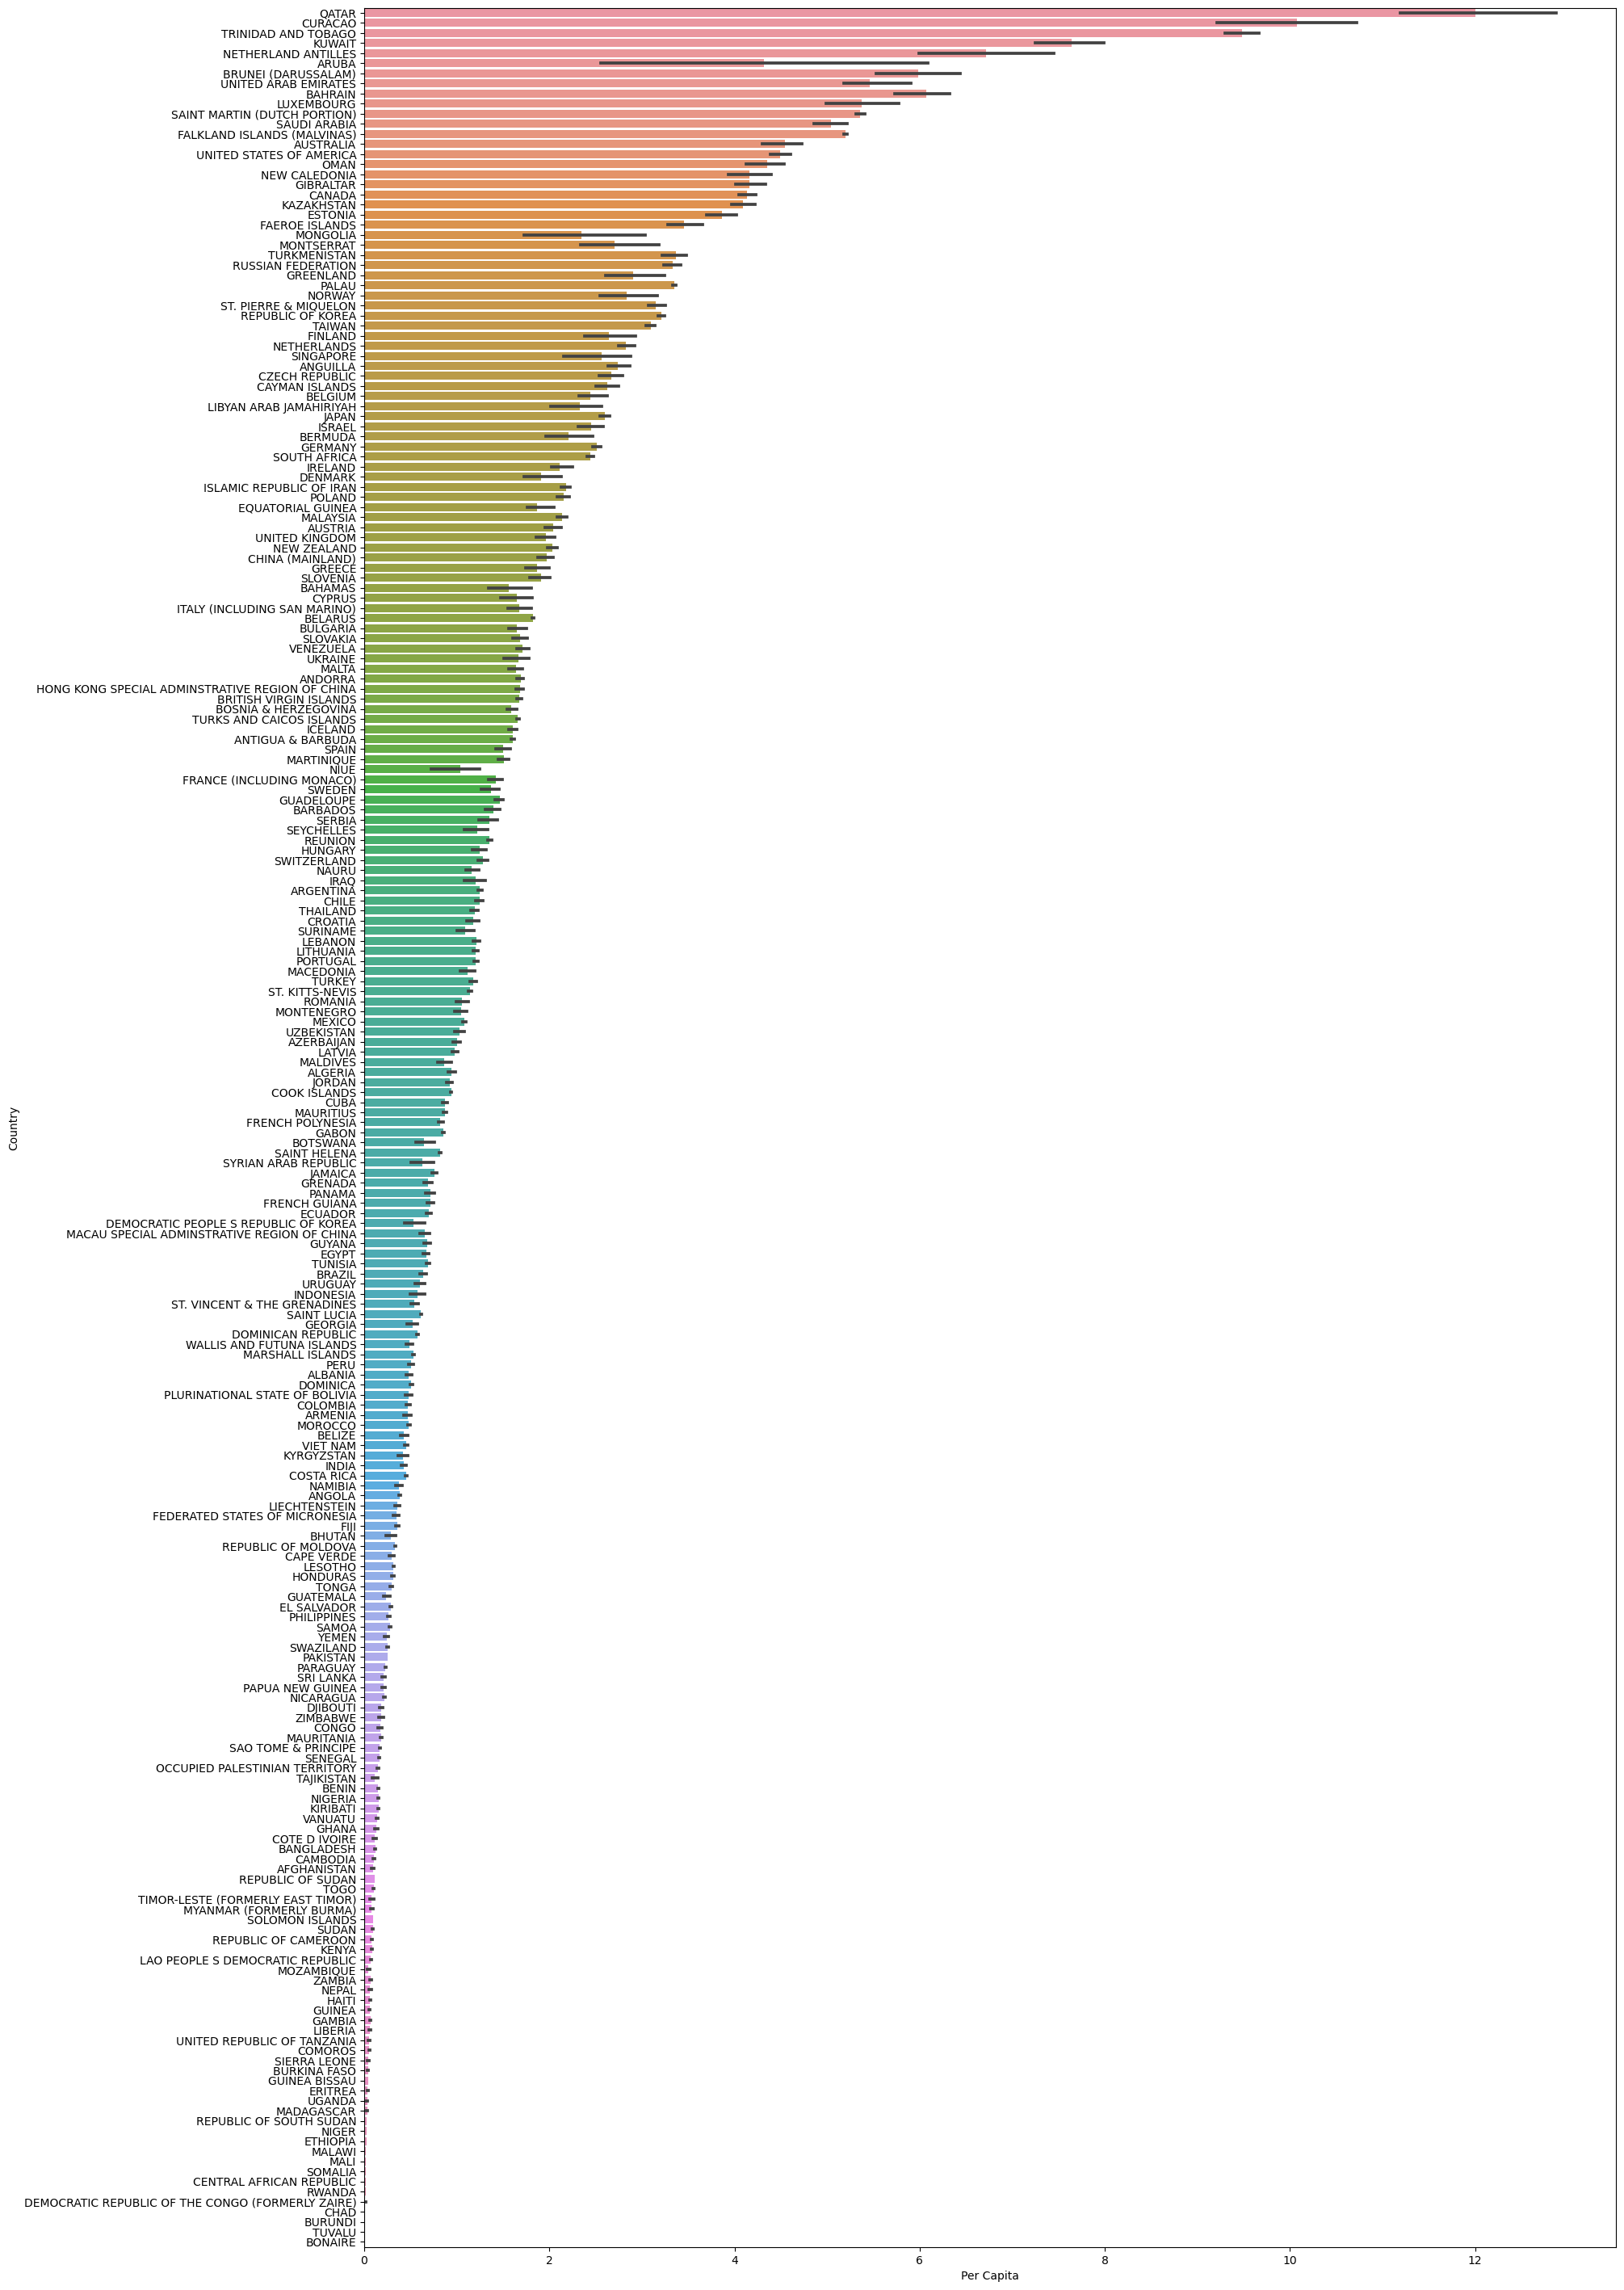

In [16]:
# Ensure inline display of plots in Jupyter notebooks
%matplotlib inline

# Sort the DataFrame by the 'Per Capita' column in descending order
sorted_df = df_raw_copy.sort_values(by=['Per Capita'], ascending=False)

# Extract the 'Country' column for plotting
country = sorted_df['Country']

# Create a figure and axis with a specified size
fig, ax = plt.subplots(figsize=(20, 36))

# Create a horizontal bar plot using Seaborn, plotting 'Per Capita' against 'Country'
sns.barplot(ax=ax, orient='h', x=sorted_df['Per Capita'], y=sorted_df['Country'], label="CO2 Per Capita by Country")

# Display the plot
plt.show()


From the graphs we can interpret that:

* CO2 emissions have been increasing from 2010 to 2014.
* Per Capita CO2 emissions are higher in industrialized countries than in developing countries.
* Qatar is the country with the most emissions per capita.

Now it is necessary to identify if there is non-relevant data and if so, know what these are. In this case Pandas can easily help us obtain the correlation matrix of the dataframe we are working with:

In [17]:
df_raw_correlation_matrix = df_raw_copy.corr(numeric_only = True) #use numeric values only!
df_raw_correlation_matrix

,Year,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
Year,1.000000,0.002064,0.002705,0.003821,0.008915,0.001422,-0.005212,-0.001873
Solid Fuel,0.002064,1.000000,0.652587,0.366057,0.970913,0.047607,0.064453,0.311448
Liquid Fuel,0.002705,0.652587,1.000000,0.860807,0.499596,0.287635,0.174801,0.606601
Gas Fuel,0.003821,0.366057,0.860807,1.000000,0.207954,0.465992,0.237138,0.592665
Cement,0.008915,0.970913,0.499596,0.207954,1.000000,0.025780,0.030316,0.202697
Gas Flaring,0.001422,0.047607,0.287635,0.465992,0.025780,1.000000,0.063156,0.157988
Per Capita,-0.005212,0.064453,0.174801,0.237138,0.030316,0.063156,1.000000,0.246780
Bunker fuels,-0.001873,0.311448,0.606601,0.592665,0.202697,0.157988,0.246780,1.000000


In order to better understand this correlation we are going to use the `heatmap` function of the [seaborn](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) library which will show us the variables that are mostly correlated as the hot points of the matrix:


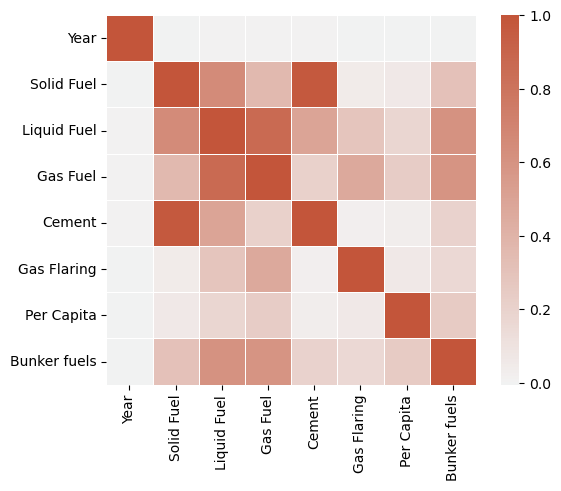

In [18]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_raw_correlation_matrix, cmap=cmap, square=True, linewidths=.5, center=0) # add , annot=True for annotations 
plt.show()

From the correlation matrix we can conclude for now that:
* CO2 emissions from Cement are strongly and positively related to Solid Fuels
* CO2 emissions Per Capita and in general the others are more related to emissions from Liquid Fuels and Gases.


Before training any machine learning model, it is important to ensure that the data used does not contain errors, such as missing or duplicate data. For this it is advisable to use a new variable, in this case `data`, which we will use to store a modified data set:

In [19]:
data = df_raw_copy.copy()


## 2. Data cleaning and preparation

Cleaning and preparing the data, justifying the decisions made based on the results obtained in the previous step.


#### Verification of missing data:
Now we will check if the dataframe contains missing values, and we will save this information:

In [20]:
absentSum = data.isna().sum()
columIndexesWithAbsentValues = [i for i,v in enumerate(absentSum) if v > 0]
print(absentSum)
print("\nColumns with absent values: " + str(columIndexesWithAbsentValues))

Year            0
Country         0
Solid Fuel      3
Liquid Fuel     3
Gas Fuel        0
Cement          0
Gas Flaring     0
Per Capita      0
Bunker fuels    0
dtype: int64

Columns with absent values: [2, 3]


There are no missing data.

#### Duplicate data check:

Now we will check if the dataframe contains duplicate values:

In [21]:
duplicatedSum = data.duplicated().sum()
duplicatedSum

0

Data does not contain duplicates


#### Elimination of irrelevant variables

Since we do not need the names or the year since we are interested in knowing the groups and causes of CO2 emitters, not when, or who, we can remove the `Country` and `Year` columns:

In [22]:
data = data.drop(['Country'], axis=1)

#### Duplicate data processing

We will include a DuplicatesRemover within the pipeline, even though the data set does not contain duplicate data.

In [23]:
duplicatedSum = data.duplicated().sum()
print(duplicatedSum)
def removeDuplicates(df):
    df = pd.DataFrame(df)
    return df.drop_duplicates()

duplicates_remover_transformer = FunctionTransformer(removeDuplicates)
duplicates_remover_transformer

0


FunctionTransformer(func=<function removeDuplicates at 0x1569509a0>)

#### Handling of missing data

Given that the dataset contains 3 missing data for `Solid Fuel`, for `Liquid Fuel` there are 3 missing data, although there are not many, we could just eliminate them. But in this case we will use a `SimpleImputer` with `mean` strategy.  Since this type of imputation applies only to numeric values, we must use a `ColumnTransformer` to assign which columns we should impute which will use the `columIndexesWithAbsentValues` variable that we created earlier to save the columns that have missing values. Also for categorical columns we will create one by default in case we need it:


In [24]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer

SimpleImputer()

#### Categorical variable transformation

We will include a **OneHot** encoding within the pipeline using an object of the class:

In [25]:
encoder = OneHotEncoder()
encoder

OneHotEncoder()

#### Standardization of numerical variables

We introduce a scaler as part of the data standardization step. We will use an object of the `StandardScaler()` class that, for each variable, eliminates the mean and scales until we reach a unit variance:

In [26]:
scaler = StandardScaler()
scaler

StandardScaler()


## 3. Construction of a clustering model using the k-means algorithm

At this point we will create a `Pipeline` which will sequence the execution of each data processing steps from cleaning, encoding, scaling and hyperparameter selection, that will produce our model.


#### Hyperparameter K selection


Initially we will create an object of class `KMeans` to run the clustering algorithm. We will specify a maximum number of iterations with the parameter `max_iter = 500` and the seed with the parameter `random_state = 77`:

In [27]:
kmeans = KMeans(max_iter=500, n_init=10, random_state=77)
kmeans

KMeans(max_iter=500, n_init=10, random_state=77)

#### Pipeline creation

We now have the transformers we need ready to build our processing and training pipeline with the `duplicates_remover`, `imputer`, `scaler` and `kmeans` objects. Now we need to define the order in which they will be invoked, for this we will create a list of pairs (name, transformer) that will define the steps to follow in processing the data:

In [28]:

steps = [
    ("duplicates_remover", duplicates_remover_transformer),
    ("imputer",imputer),
    ("transformer",scaler), 
    ("model", kmeans),
]

Now we will create an object of class `Pipeline()` to perform preprocessing, processing and training and assign the steps to it:

In [29]:
pipe = Pipeline(steps)
pipe

Pipeline(steps=[('duplicates_remover',
                 FunctionTransformer(func=<function removeDuplicates at 0x1569509a0>)),
                ('imputer', SimpleImputer()), ('transformer', StandardScaler()),
                ('model', KMeans(max_iter=500, n_init=10, random_state=77))])

Our Pipeline looks great 🤩!


### Silhouette method

For this analysis, we will use the `silhouette_score()` function of `scikit-learn`, which returns the average of the silhouette coefficient for all data in the ensemble. In that sense, an average value close to 1 would indicate that the number of clusters is appropriate for the data set, while lower values ​​would indicate that the value of _k_ does not return good clusters. We will define the function `silhouette_plot()`, which calculates the average coefficient for various values ​​of _k_ and plots them:

In [30]:
def silhouette_plot(data, k_min=2, k_max=5):
    """
    Generate the graph with the silhouette coefficient
    
    Parameters:
     data : np.array
         The arrangement with the data
     k_min : int
         Minimum value for k
     k_max : int
         Maximum value for k
    """
    scores = []
    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pipe.set_params(model__n_clusters=i)
        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        pipe.fit(data)
        # Procesamos los datos
        noDupe_data = duplicates_remover_transformer.fit_transform(data)
        imputer_data = imputer.fit_transform(noDupe_data)
        clean_data = scaler.fit_transform(imputer_data)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(clean_data, pipe['model'].labels_)
        scores.append(score)
    
    # Graficamos los valores del coeficiente de la silueta
    plt.plot(range(k_min,k_max+1), scores, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

We will see the behavior of the coefficient for our data set:

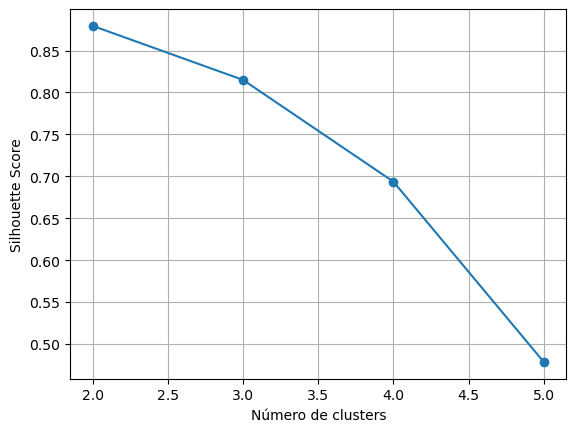

In [31]:
silhouette_plot(data)

#### What is the value of the silhouette coefficient for the selected number of groups?

According to the graph we can interpret that the best value of _k_ is **2** since it is the closest value to 1



**The Silhouette Coefficient for the selected number of groups is `k = 2`**. With the best value of `k = 2`, we will first run the `KMeans` algorithm:

In [32]:
pipe.set_params(model__n_clusters=2)
pipe.fit(data)

Pipeline(steps=[('duplicates_remover',
                 FunctionTransformer(func=<function removeDuplicates at 0x1569509a0>)),
                ('imputer', SimpleImputer()), ('transformer', StandardScaler()),
                ('model',
                 KMeans(max_iter=500, n_clusters=2, n_init=10,
                        random_state=77))])

Let's proceed to extract the labels of the resulting groups

In [33]:
labels = pipe['model'].labels_
indexes, values = np.unique(labels, return_counts=True)
{indexes[i]: values[i] for i in range(len(indexes))}

{0: 1084, 1: 10}

Now let's see what our groups look like in a bar graph:

([<matplotlib.axis.XTick at 0x15113ced0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

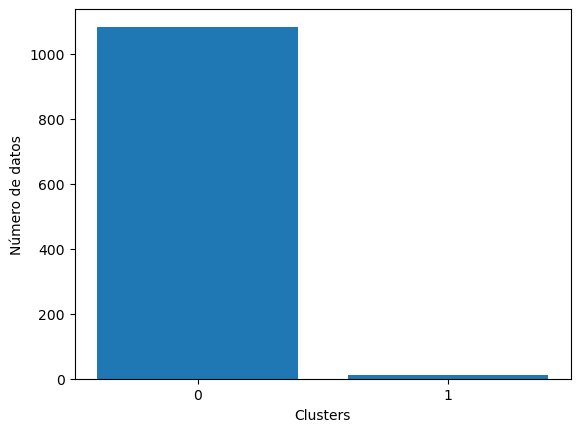

In [34]:
%matplotlib inline

rects = plt.bar(indexes, values)
plt.xlabel('Clusters')
plt.ylabel('Número de datos')
plt.xticks(indexes)

Now we will obtain the centroids as data frames and we will apply the inverse of our `scaler` to descale the data:

In [35]:
centroids_array = pipe['model'].cluster_centers_
centroids_transformed = scaler.inverse_transform(centroids_array)
print(centroids_transformed.shape)
print(data.shape)
centroids = pd.DataFrame(centroids_transformed, columns=data.columns)
centroids

(2, 8)
(1094, 8)


,Year,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
0,2012.008303,7.119531e+03,8648.672538,6101.360701,949.663284,290.528598,1.375258,1193.950185
1,2012.000000,1.226145e+06,447963.100000,222724.900000,155113.100000,1671.900000,3.231000,23430.800000


## 4. Interpretation of the resulting groups from the best model

#### Based on the best value of the silhouette coefficient, do you consider that the performance of the model is adequate? If not, how could the results be improved?

We can observe that the grouping model has generated two groups of countries, where class 0 is quite unbalanced compared to class 1. This result shows that the highest CO2 emission is produced from liquid fuels (and secondly , solid fuels), which are mainly used for the propulsion of vehicles. The model discriminates between two groups of countries: those that emit more CO2 using liquid and solid fuels, and those that do not.

Let's see what interpretation we can give with a decision tree

#### Construction of a decision tree model
To carry out this task we will apply an algorithm based on decision trees using groups as a class label. This algorithm will only be used for explanatory purposes:

[Text(0.5, 0.8333333333333334, 'Liquid Fuel <= 4.356\ngini = 0.5\nsamples = 1094\nvalue = [547.0, 547.0]\nclass = Grupo 1'),
 Text(0.25, 0.5, 'Solid Fuel <= -0.131\ngini = 0.0\nsamples = 1084\nvalue = [547.0, 0.0]\nclass = Grupo 1'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 481\nvalue = [242.719, 0.0]\nclass = Grupo 1'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 603\nvalue = [304.281, 0.0]\nclass = Grupo 1'),
 Text(0.75, 0.5, 'Liquid Fuel <= 6.024\ngini = 0.0\nsamples = 10\nvalue = [0, 547]\nclass = Grupo 2'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0.0, 54.7]\nclass = Grupo 2'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 9\nvalue = [0.0, 492.3]\nclass = Grupo 2')]

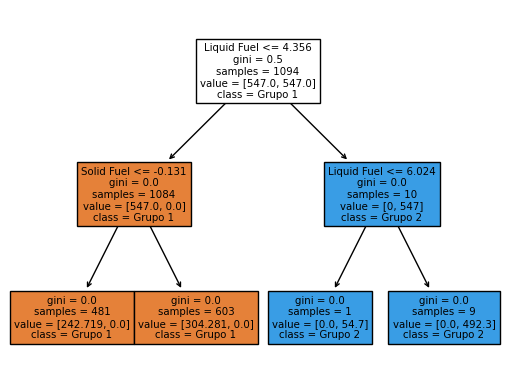

In [36]:
# Create the pipeline with its steps 
tree_steps = [
    ("duplicates_remover", duplicates_remover_transformer),
    ("imputer",imputer),
    ("transformer",scaler), 
]
pipeline = Pipeline(tree_steps)

# Save columns and transform data
data_columns = data.columns
x_train_transformed = pipeline.fit_transform(data)

# Create tree, train it with transformed data and KMeans Labels, plot the tree
decision_tree = DecisionTreeClassifier(max_depth=15, class_weight='balanced', random_state=77)
modelo = decision_tree.fit(x_train_transformed, labels)
tree.plot_tree(modelo, feature_names=list(data_columns), class_names=['Grupo 1','Grupo 2'], filled=True)



#### What are the rules that characterize each group based on the explanatory tree? Reflect on how this new knowledge could help make decisions in the context of the problem?


* **Liquid Fuel <= 4.356**: This appears to be the main rule that splits the data into two groups based on the "Liquid Fuel" value. If the value of this characteristic is less than or equal to 4.356, it is classified in "Group 1", otherwise it goes to the next rule.
* **Solid Fuel <= -0.131**: This second rule is applied when the first rule is met. It further divides the data into "Group 1" based on the "Solid Fuel" value. If the value of this feature is less than or equal to -0.131, the data is classified into "Group 1".
* **Gini = 0.0**: Indicates that the purity of the classification in this tree leaf is maximum. All items on this sheet belong to "Group 1". There is no mix of classes on this sheet.
* **Gini = 0.0**: Similarly, this sheet also has maximum purity with all elements classified as "Group 1". This means that the classification based on "Solid Fuel" is very accurate on this subset of data.
* **Liquid Fuel <= 6.024**: This rule is applied when the first rule is not satisfied (when the value of "Liquid Fuel" is greater than 4.356). Divides the data into "Group 2" if the value of "Liquid Fuel" is less than or equal to 6.024.
* **Gini = 0.0**: Like the previous sheets, this sheet has a maximum purity. All items on this sheet belong to "Group 2", which means that the classification based on "Liquid Fuel" is very accurate here.

The leaves of the tree are pure, suggesting good classification ability on these characteristics. Based on the structure of our tree, let's corroborate this information in a graph to see which countries burn liquid and solid fuels the most:

Found NaN values in 'Liquid Fuel' column, filling NaNs with the column mean.
Found NaN values in 'Solid Fuel' column, filling NaNs with the column mean.


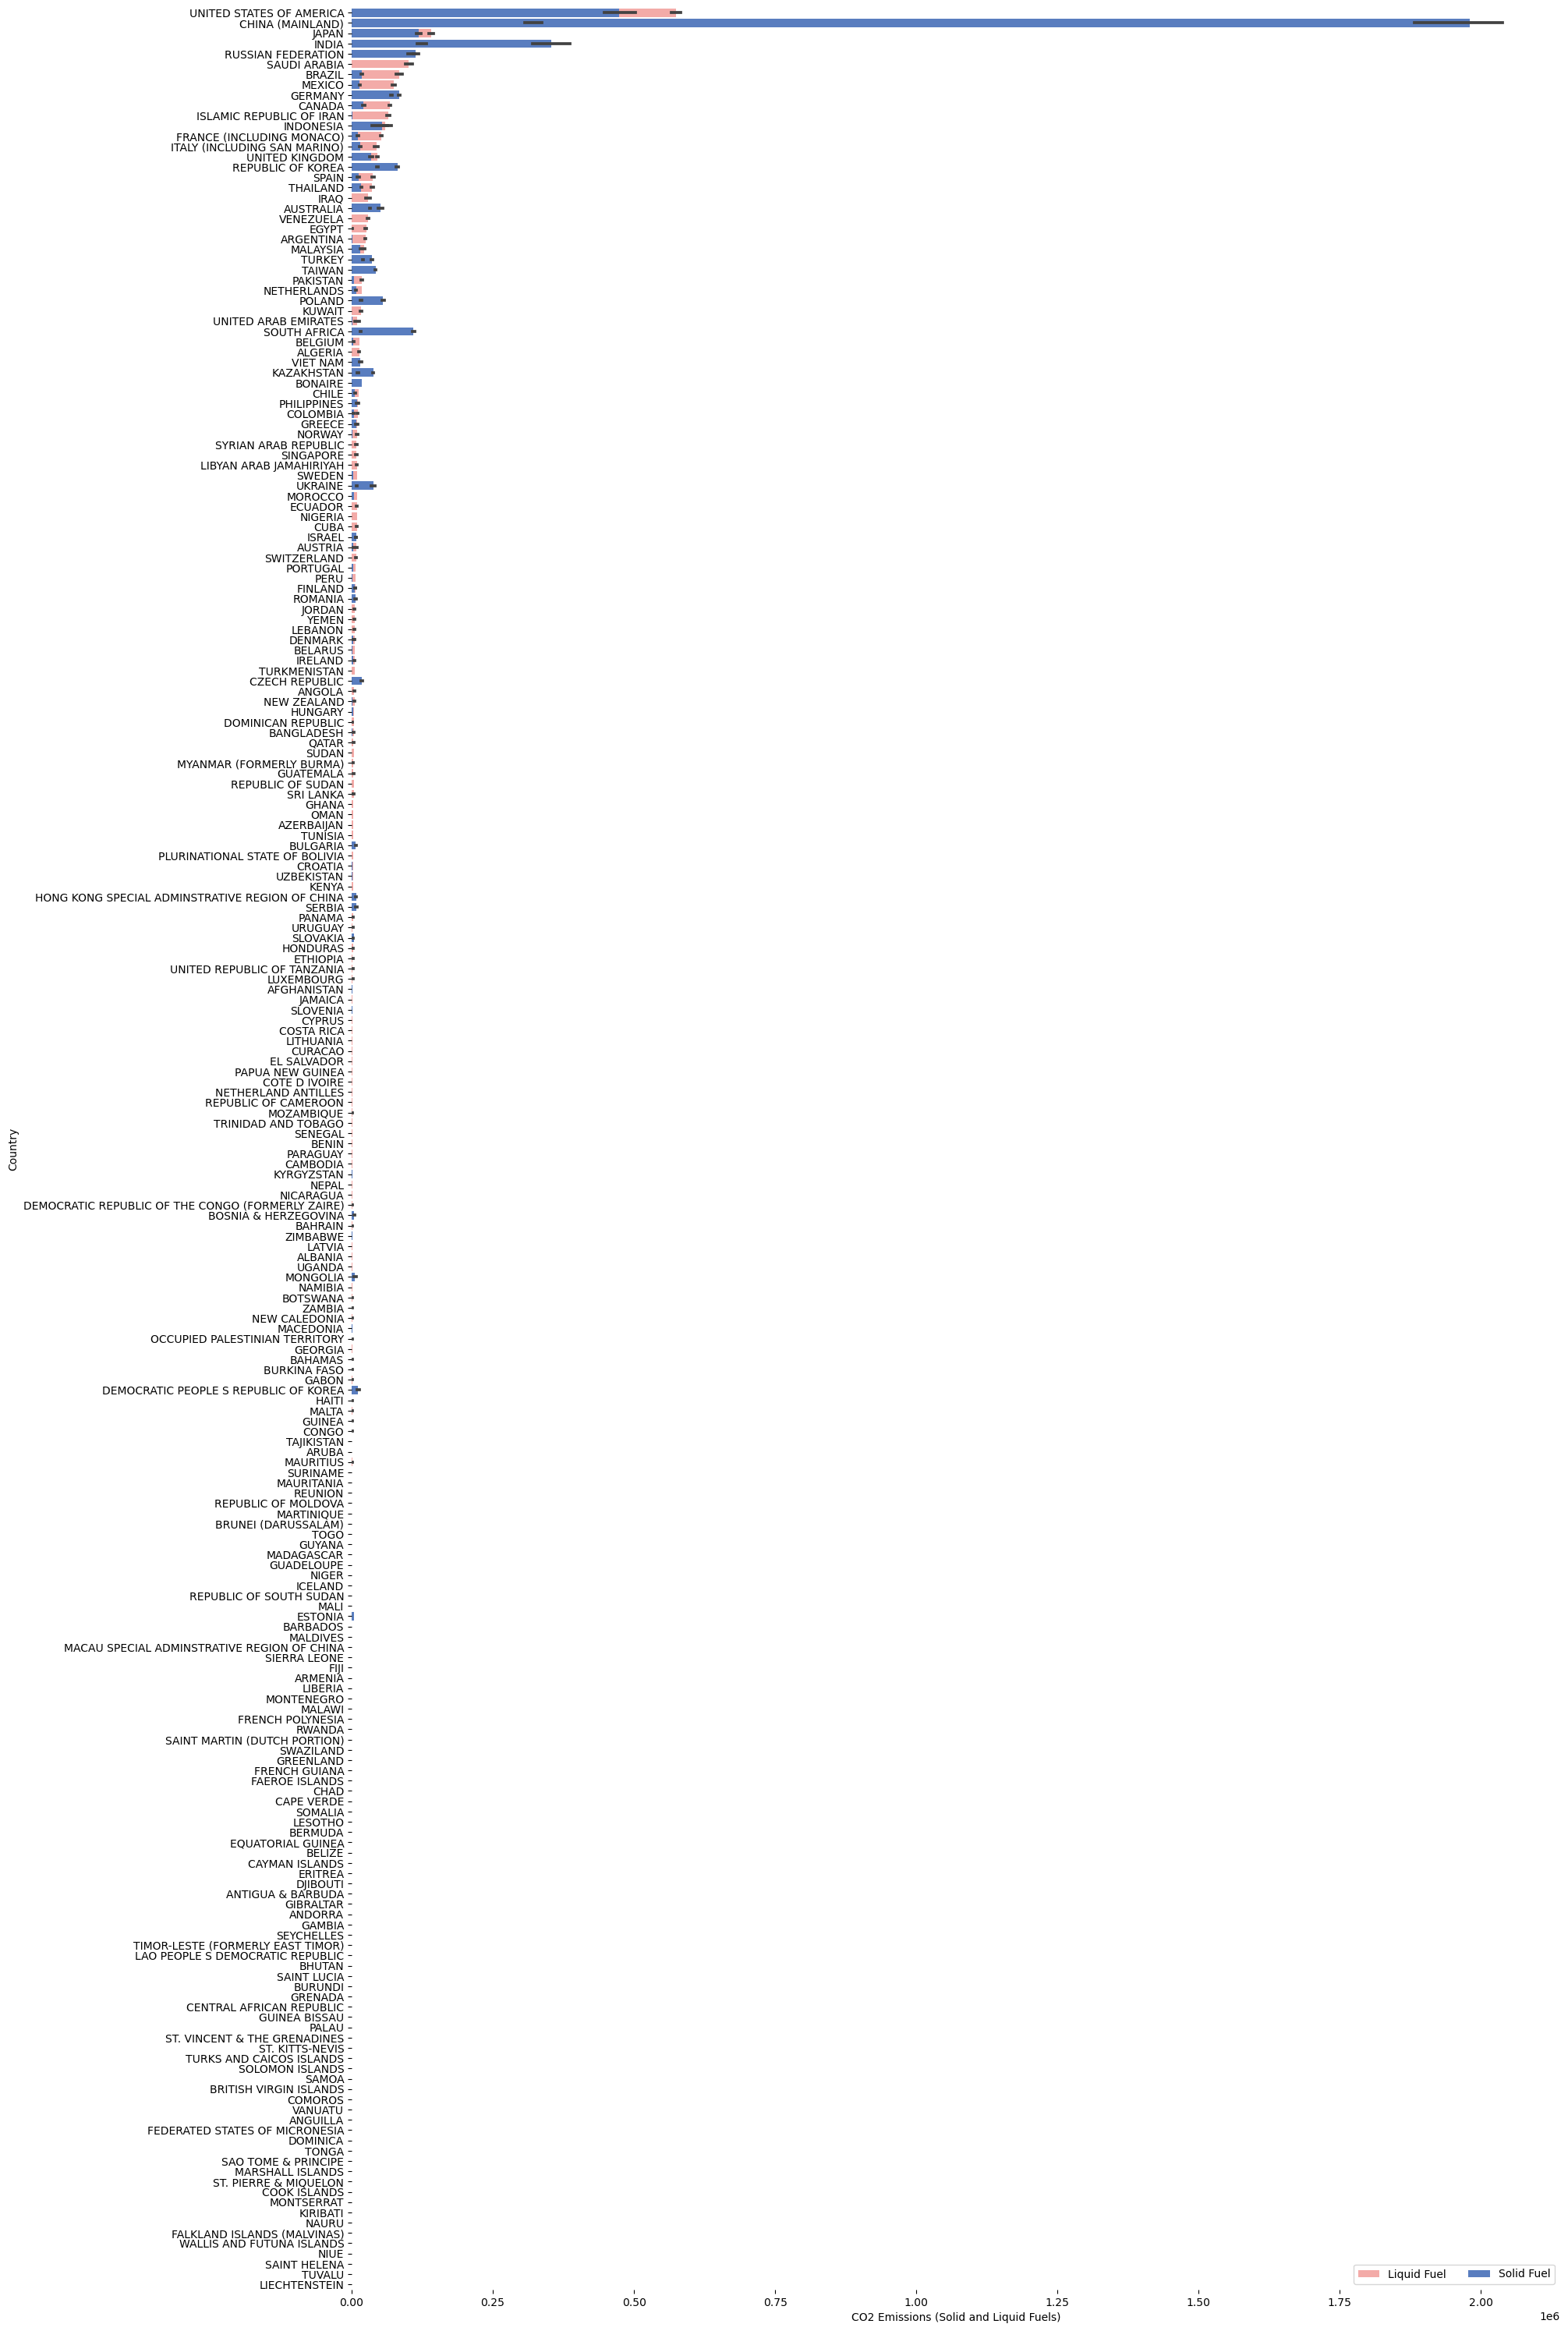

In [36]:

# Ensure inline display of plots in Jupyter notebooks
%matplotlib inline

# Check for NaN values in 'Liquid Fuel' and 'Solid Fuel' columns and handle them
if df_raw_copy['Liquid Fuel'].isnull().sum() > 0:
    print("Found NaN values in 'Liquid Fuel' column, filling NaNs with the column mean.")
    df_raw_copy['Liquid Fuel'].fillna(df_raw_copy['Liquid Fuel'].mean(), inplace=True)

if df_raw_copy['Solid Fuel'].isnull().sum() > 0:
    print("Found NaN values in 'Solid Fuel' column, filling NaNs with the column mean.")
    df_raw_copy['Solid Fuel'].fillna(df_raw_copy['Solid Fuel'].mean(), inplace=True)

# Sort the DataFrame by the 'Liquid Fuel' column in descending order
sorted_df = df_raw_copy.sort_values(by=['Liquid Fuel'], ascending=False)

# Extract the 'Country' column for plotting
country = sorted_df['Country']

# Create a figure and axis with a specified size
fig, ax = plt.subplots(figsize=(20, 38))

# Set color codes for the plots
sns.set_color_codes("pastel")

# Create a horizontal bar plot for 'Liquid Fuel' emissions
sns.barplot(ax=ax, orient='h', x=sorted_df['Liquid Fuel'], y=sorted_df['Country'], color="r", label='Liquid Fuel')

# Set color codes for the plots
sns.set_color_codes("muted")

# Create a horizontal bar plot for 'Solid Fuel' emissions
sns.barplot(ax=ax, orient='h', x=sorted_df['Solid Fuel'], y=sorted_df['Country'], color="b", label='Solid Fuel')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Country",
       xlabel="CO2 Emissions (Solid and Liquid Fuels)")
sns.despine(left=True, bottom=True)

# Display the plot
plt.show()

## 5 Results

Among the 1094 data samples analyzed from different countries in relation to CO2 emissions. It was found that the clustering model has divided the data set into two main groups, which we could call "Group 1" and "Group 2".
* Group 1: This group appears to represent countries with CO2 emissions mainly related to the use of liquid fuels. Within this group, a subdivision is observed into two subgroups:
* Subgroup 1.1: Includes countries with CO2 emissions related to the use of solid fuels, and these emissions are practically zero.
* Subgroup 1.2: Includes countries with CO2 emissions related to the use of liquid fuels, and these emissions are significant.
* Group 2: This group appears to represent countries with CO2 emissions mainly related to the use of liquid fuels, but in this case, the emissions are much higher than in Subgroup 1.2 of Group 1.

Group 1 has countries with low or no CO2 emissions related to solid fuels, while Group 2 has countries with significant emissions related to liquid fuels.


#### In this context and based on the characteristics of the problem, what other evaluation techniques do you think you could apply?

* **Inertia**: The inertia metric measures how much the points within each group vary with respect to the center of the group. A lower inertia value indicates better clustering. You can help determine the optimal number of groups by using the "elbow" on the inertia graph.

* **Principal Component Analysis (PCA)**: If you have high-dimensional features, PCA can help reduce the dimensionality of the data before applying K-Means and evaluating the quality of the resulting groups. This could be applied once the categorical variable name is included, which after the application of an encoder, triggers the dimensionality of the model.

* **Visualization of groups**: Using visualizations such as scatterplots or heat maps to visualize the groups and check if they make sense from a practical perspective.